# Sparkify Project Workspace

### Problem Introduction
This notebook takes in data from the music streaming service Sparkify and explores its data to identify users who are likely to cancel/churn. Churn prediction is an important business objective, as it allows businesses to identify and potentially retain users that may be likely to cancel.

### Strategy to solve the problem
Sparkify has recorded data which contains information on all user interactions with their service between 01/10/2018 and 01/12/2018. I will analyse this data to see if any patterns can be extracted on users who cancel their subscriptions. Armed with this information, Sparkify could target such customers and develop a strategy to retain them.

In [1]:
# install spark
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 35 kB/s 
     |████████████████████████████████| 200 kB 54.3 MB/s 
     |████████████████████████████████| 199 kB 72.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=379655effcad550fe0712e1ecb9c6b633c798bcc15caf568624a1439d5b93265
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [411]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

# import spark libraries
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType, DateType, FloatType
from pyspark.sql.functions import desc, asc
from pyspark.sql.functions import desc, asc, isnan, sum as Fsum, col, when, count, avg, from_unixtime, from_utc_timestamp, max as Fmax, datediff
from pyspark.sql import SparkSession, Window

from pyspark.ml.classification import NaiveBayes, GBTClassifier, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [3]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

## Load and Explore Dataset

In [4]:
# give google drive permissions
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# import data
df_data_1 = spark.read.json('/content/drive/MyDrive/Colab Notebooks/medium-sparkify-event-data.json')
df_data_1.persist() # store dataframe in memory instead of reading from disk every time - improves performance
df_data_1.show(2) # display first two rows

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98')]

In [6]:
# display data columns
df_data_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



- SessionId should be a string type

In [7]:
#Count of non-null for all columns
from pyspark.sql.functions import col, when, count
df_data_1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_data_1.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110829|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



- Looks like all empty artist rows will also have empty length and song rows.
- The same applies for first Name, gender, last name, location, registration and user agent.
- Remove empty userId records

In [11]:
# view auth values where user agent are last name (and other columns) are null
df_data_1.filter(df_data_1.userAgent.isNull() & df_data_1.lastName.isNull()).select(['auth']).dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [12]:
# view page values where user agent are last name (and other columns) are null
df_data_1.filter(df_data_1.userAgent.isNull() & df_data_1.lastName.isNull()).select('page').dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



- Looks like the null lastName etc rows are logged out users or guests. This makes sense - we shouldn't have information for them if they are not registered users.

In [14]:
# view rows where user agent are last name (and other columns) are null
df_data_1.filter(df_data_1.artist.isNull()).sample(0.1).take(5)

[Row(artist=None, auth='Logged In', firstName='Maverick', gender='M', itemInSession=185, lastName='Santiago', length=None, level='paid', location='Orlando-Kissimmee-Sanford, FL', method='PUT', page='Logout', registration=1535953455000, sessionId=178, song=None, status=307, ts=1538352119000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='179'),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=186, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=178, song=None, status=200, ts=1538352148000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=187, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=178, song=None, status=200, ts=1538352151000, userAgent=None, userId=''),
 Row(artist=N

In [15]:
# check that all null artist rows are also null user agent rows
mask = df_data_1.artist.isNull() & df_data_1.userAgent.isNull()
df_data_1.filter(mask).count()

15700

- All null artist rows are also null user agent (etc) rows

In [16]:
# view page values where artist (and other columns) is null
df_data_1.filter(df_data_1.artist.isNull()).select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
+--------------------+
only showing top 20 rows



In [17]:
# view page values where artist (and other columns) is null
df_data_1.filter(df_data_1.artist.isNull()).select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
+--------------------+
only showing top 20 rows



In [18]:
# view page values where artist (and other columns) is not null
df_data_1.filter(df_data_1.artist.isNotNull()).select('page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



- All null artist rows relate to users actions that are not "NextSong"

In [19]:
# check for blank user ids
df_data_1.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



- Remove empty userId records

## Data Cleaning

#### Filter out blank user ID rows

In [26]:
# filter out blank user ids
df_data_2 = df_data_1.filter(df_data_1['userId'] != '')

In [27]:
# check blank user ids removed
df_data_2.select('userId').dropDuplicates().sort('userId').show(2)

+------+
|userId|
+------+
|    10|
|   100|
+------+
only showing top 2 rows



#### Cast session ID to string type

In [28]:
# change session id to string type
df_data_3 = df_data_2.withColumn('sessionId', col('sessionId').cast(StringType()))

In [29]:
# check the change
df_data_3.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [30]:
# check that registration is unique for each user
df_data_3.select(['registration', 'userId']).dropDuplicates().count() == df_data_3.select(['userId']).dropDuplicates().count()

True

#### Add readable date columns



In [31]:
# create readable date column
from pyspark.sql.functions import unix_timestamp
df_data_3 = df_data_3.withColumn('time', from_unixtime(col('ts')/ 1000,"yyyy-MM-dd HH:mm:ss:SSS").cast(DateType()))

# create readable registration date column
df_data_3 = df_data_3.withColumn('registration_time', from_unixtime(col('registration')/ 1000,"yyyy-MM-dd HH:mm:ss:SSS").cast(DateType()))

In [32]:
# check change
df_data_3.select(['time','ts']).sort(desc('ts')).show(5)

+----------+-------------+
|      time|           ts|
+----------+-------------+
|2018-12-01|1543622466000|
|2018-12-01|1543622405000|
|2018-12-01|1543622404000|
|2018-12-01|1543622401000|
|2018-11-30|1543622393000|
+----------+-------------+
only showing top 5 rows



In [33]:
df_data_3.sort(asc('time')).show(1)

+------+---------+-----------+------+-------------+--------+------+-----+-----------+------+----+-------------+---------+----+------+-------------+--------------------+------+----------+-----------------+
|artist|     auth|  firstName|gender|itemInSession|lastName|length|level|   location|method|page| registration|sessionId|song|status|           ts|           userAgent|userId|      time|registration_time|
+------+---------+-----------+------+-------------+--------+------+-----+-----------+------+----+-------------+---------+----+------+-------------+--------------------+------+----------+-----------------+
|  null|Logged In|Christopher|     M|            0|   Perez|  null| free|Rutland, VT|   GET|Home|1534537891000|       49|null|   200|1538352802000|"Mozilla/5.0 (Mac...|100049|2018-10-01|       2018-08-17|
+------+---------+-----------+------+-------------+--------+------+-----+-----------+------+----+-------------+---------+----+------+-------------+--------------------+------+-----

In [34]:
# check change
df_data_3.select(['registration','registration_time']).dropDuplicates().sort(desc('registration')).show(5)

+-------------+-----------------+
| registration|registration_time|
+-------------+-----------------+
|1543073874000|       2018-11-24|
|1542205030000|       2018-11-14|
|1541041865000|       2018-11-01|
|1539437340000|       2018-10-13|
|1538347306000|       2018-09-30|
+-------------+-----------------+
only showing top 5 rows



### Exploratory Data Analysis

In [35]:
# data length
df_data_3.count()

528005

In [36]:
# filter for random sample of data
proportion = 0.1
df_data_3_sample = df_data_3.sample(proportion)

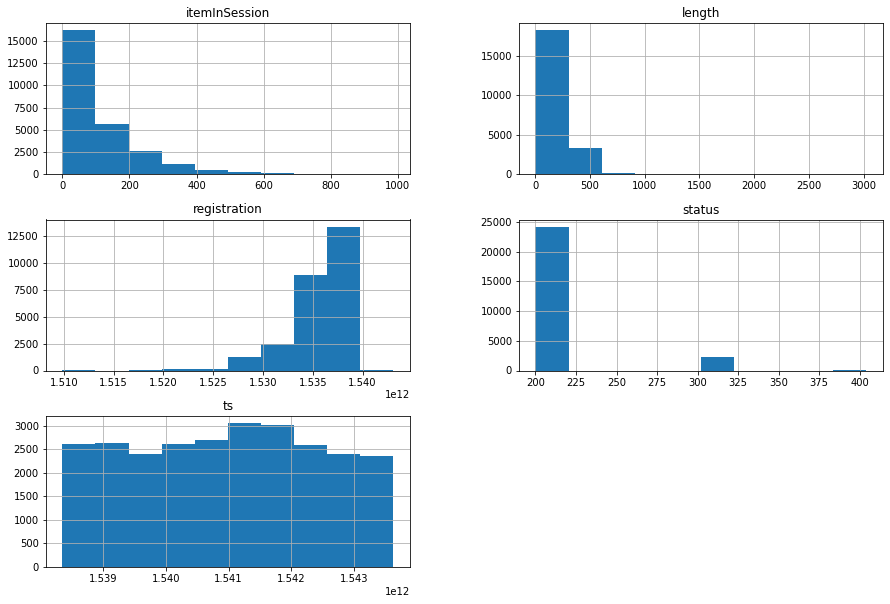

In [37]:
# view histogram of numeric variables
df_data_3_sample_pd = df_data_3_sample.toPandas()
df_data_3_sample_pd.hist(figsize=(15, 10))
plt.show()

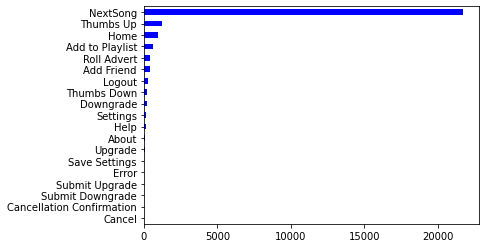

In [38]:
# view distribution page actions
df_data_3_sample_pd.page.value_counts().sort_values(ascending=True).plot(kind='barh', color='blue');

## Feature Engineering And Further Data Exploration

In [39]:
# create churn column
def_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_data_4 = df_data_3.withColumn('churn', def_churn(df_data_3.page))

In [40]:
# create window to map users who have cancelled
windowval = Window.partitionBy('userId')
df_data_5 = df_data_4.withColumn('churn_ind', Fmax('churn').over(windowval))

In [41]:
# view data
df_data_5.where(df_data_5.userId == '125').select(['page','churn','churn_ind', 'ts']).sort(asc('churn_ind')).show()

+---------------+-----+---------+-------------+
|           page|churn|churn_ind|           ts|
+---------------+-----+---------+-------------+
|Add to Playlist|    0|        0|1542265610000|
|       NextSong|    0|        0|1542265592000|
|    Roll Advert|    0|        0|1542265262000|
|       NextSong|    0|        0|1542265244000|
|    Roll Advert|    0|        0|1542265064000|
|       NextSong|    0|        0|1542265046000|
|       NextSong|    0|        0|1542264493000|
|           Home|    0|        0|1542264481000|
|    Roll Advert|    0|        0|1540232239000|
|       NextSong|    0|        0|1540232189000|
|       NextSong|    0|        0|1540231988000|
|       NextSong|    0|        0|1540231833000|
|       NextSong|    0|        0|1540231522000|
|       NextSong|    0|        0|1540231332000|
|       NextSong|    0|        0|1540231011000|
|       NextSong|    0|        0|1540230877000|
|           Help|    0|        0|1540230751000|
|           Help|    0|        0|1540230

In [42]:
# average length by churn
df_data_5.groupBy('churn_ind').agg(avg('length')).show()

+---------+------------------+
|churn_ind|       avg(length)|
+---------+------------------+
|        0|248.58486352452653|
|        1|248.99398360601577|
+---------+------------------+



In [43]:
# total row count by churn
df_data_5.filter(df_data_5.page == 'NextSong').groupBy('churn_ind').count().show()

+---------+------+
|churn_ind| count|
+---------+------+
|        0|348518|
|        1| 84359|
+---------+------+



In [44]:
# count of each churn row
user_actions_count = df_data_5.groupBy('churn_ind').count().toPandas()

# count of each page action by churn group
user_page_actions_count = df_data_5.groupBy(['churn_ind', 'page']).count().toPandas()

# normalise user action count by the total number of user actions
user_actions_normalised = user_page_actions_count.copy()
churn_mask_0 = user_actions_normalised.churn_ind==0
user_actions_normalised.loc[churn_mask_0,'count'] = \
                        user_actions_normalised[churn_mask_0]['count']\
                        / user_actions_count.loc[0]['count']

churn_mask_1 = user_actions_normalised.churn_ind==1
user_actions_normalised.loc[churn_mask_1,'count'] = \
                        user_actions_normalised[churn_mask_1]['count']\
                        / user_actions_count.loc[1]['count']

user_actions_normalised.head()

,churn_ind,page,count
0,0,Save Settings,0.001133
1,1,Thumbs Up,0.041487
2,1,Add Friend,0.014829
3,1,Add to Playlist,0.021795
4,0,Settings,0.005526


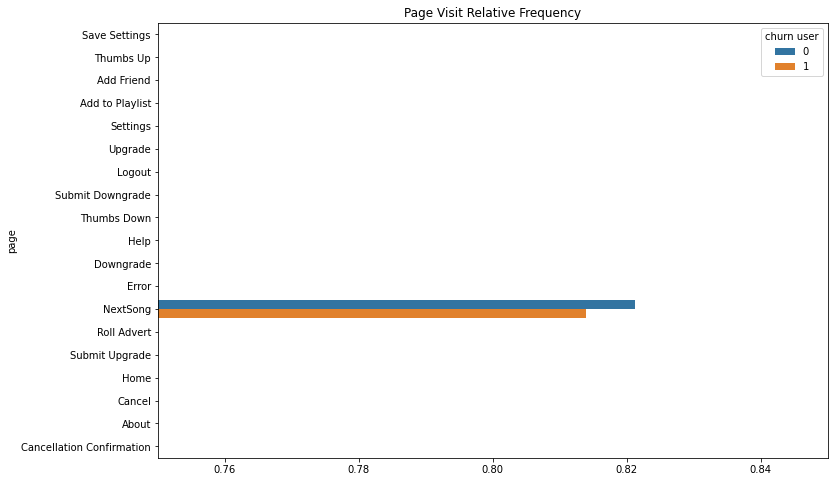

In [45]:
# plot relative page visit frequency
plt.figure(figsize=(12,8))
sns.barplot(data=user_actions_normalised, y='page', x='count', hue='churn_ind')
plt.title('Page Visit Relative Frequency')
plt.xlim(0.75,0.85)
plt.legend(title='churn user')
plt.xlabel('');

- Users who cancel spend less time relatively listening to songs

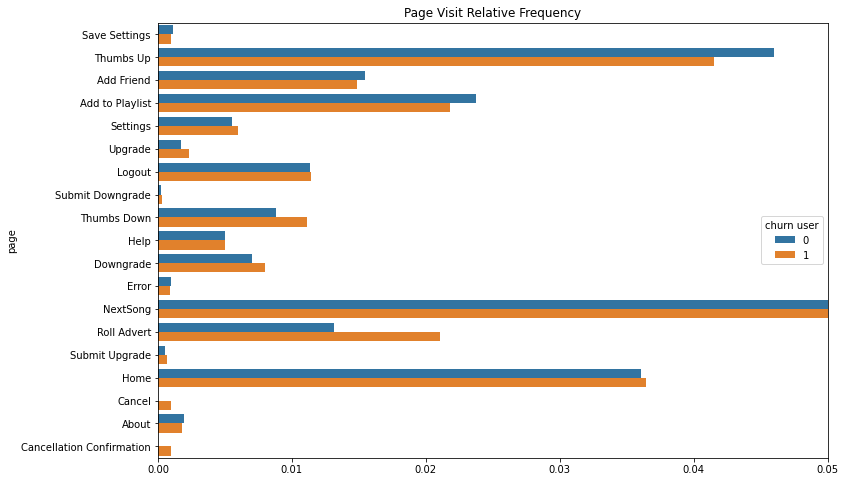

In [46]:
# plot relative page visit frequency
plt.figure(figsize=(12,8))
sns.barplot(data=user_actions_normalised, y='page', x='count', hue='churn_ind')
plt.title('Page Visit Relative Frequency')
plt.xlim(0,0.05)
plt.legend(title='churn user')
plt.xlabel('');

- Churn Users:
    - Thumbs down, Logout, Roll Adverts more often than users who don't churn
    - Thumbs up, Add Friend less often than users who don't churn
    

In [75]:
df_data_5.createOrReplaceTempView("df")

# create churn indicator over the final week
df_data_6 = spark.sql(
    """SELECT *, SUM(churn) OVER (
        PARTITION BY userId 
        ORDER BY CAST(time AS timestamp) 
        RANGE BETWEEN INTERVAL 7 DAYS PRECEDING AND CURRENT ROW
     ) AS final_week_churn_ind FROM df""")

In [76]:
# convert to pandas for further analysis
df_data_6_pd = df_data_6.toPandas()

In [77]:
# count user actions by page in final week before cancellation
user_page_actions_final_week = df_data_6_pd.groupby(['final_week_churn_ind','page']).count()['auth'].reset_index()
# count total user actions in final week before cancellation
user_count_final_week = df_data_6_pd.groupby(['final_week_churn_ind'])['page'].count()
user_page_actions_final_week.rename(columns={'auth': 'count'}, inplace=True)

In [78]:
# normalise user action count by the total number of user actions
user_actions_normalised_fw = user_page_actions_final_week.copy()
churn_mask_0 = user_actions_normalised_fw.final_week_churn_ind==0
user_actions_normalised_fw.loc[churn_mask_0,'count'] = \
                        user_actions_normalised_fw[churn_mask_0]['count']\
                        / user_count_final_week.loc[0]

churn_mask_1 = user_actions_normalised_fw.final_week_churn_ind==1
user_actions_normalised_fw.loc[churn_mask_1,'count'] = \
                        user_actions_normalised_fw[churn_mask_1]['count']\
                        / user_count_final_week.loc[1]

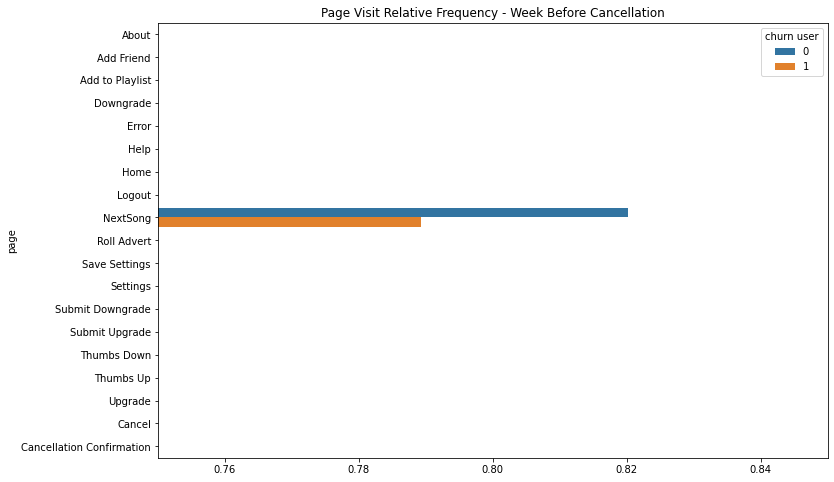

In [483]:
# plot relative page visit frequency during the week before cancellation
plt.figure(figsize=(12,8))
sns.barplot(data=user_actions_normalised_fw, y='page', x='count', hue='final_week_churn_ind')
plt.xlim(0.75,0.85)
plt.title('Page Visit Relative Frequency - Week Before Cancellation')
plt.legend(title='churn user')
plt.xlabel('');

- The same trend as before is observed: Users who cancel listen to fewer songs
- However, this difference is even greater in the final week.

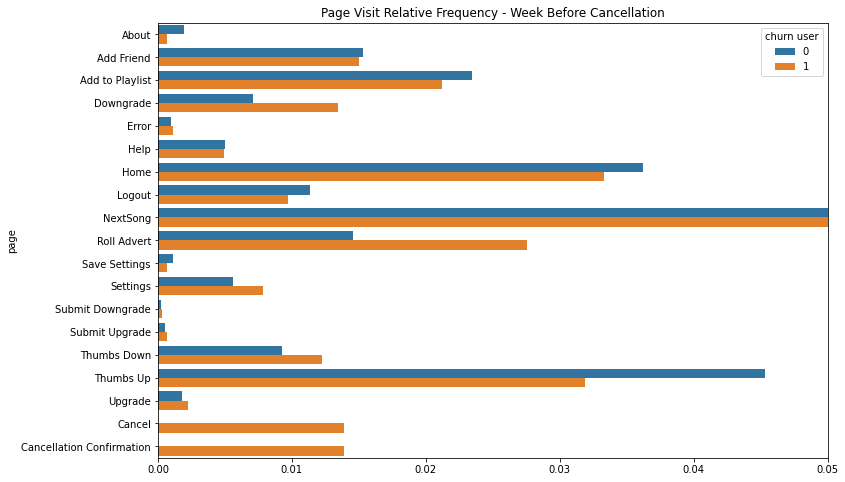

In [482]:
# plot relative page visit frequency during the week before cancellation
plt.figure(figsize=(12,8))
sns.barplot(data=user_actions_normalised_fw, y='page', x='count', hue='final_week_churn_ind')
plt.xlim(0,0.05)
plt.title('Page Visit Relative Frequency - Week Before Cancellation')
plt.legend(title='churn user')
plt.xlabel('');

- The same trends as before are observed i.e.
    - Churn Users:
        - Thumbs down, Logout, Roll Adverts more often than users who don't churn
        - Thumbs up, Add Friend less often than users who don't churn
- However, Churn Users in the final week also visit:
    - Downgrade and Settings pages more frequently.
    

#### Lets look at some of these individual variable trends for the more frequently used page actions.

In [149]:
users_pageAction_count = df_data_6.groupby(['userId', 'churn_ind','page']).agg(count('page')).sort('userId').toPandas()

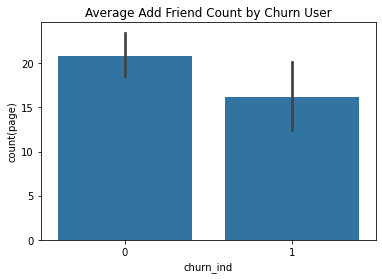

In [188]:
sns.barplot(data=users_pageAction_count.query('page=="Add Friend"'), x='churn_ind', y='count(page)', color=base_colour)
plt.title('Average Add Friend Count by Churn User');

Non-churn users add more friends than churn users.

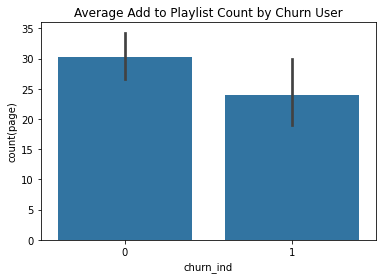

In [187]:
sns.barplot(data=users_pageAction_count.query('page=="Add to Playlist"'), x='churn_ind', y='count(page)', color=base_colour)
plt.title('Average Add to Playlist Count by Churn User');

Non-churn users add songs to playlists more than churn users

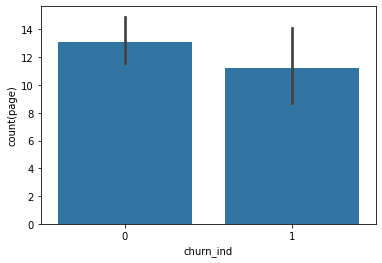

In [171]:
sns.barplot(data=users_pageAction_count.query('page=="Downgrade"'), x='churn_ind', y='count(page)', color=base_colour);

Not much difference seen here

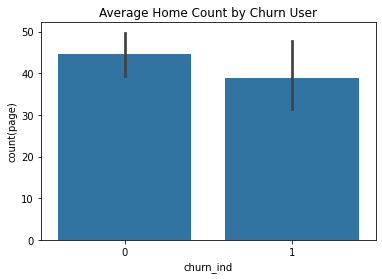

In [189]:
sns.barplot(data=users_pageAction_count.query('page=="Home"'), x='churn_ind', y='count(page)', color=base_colour)
plt.title('Average Home Count by Churn User');

Non-churn users use the home button slightly more than churn users.

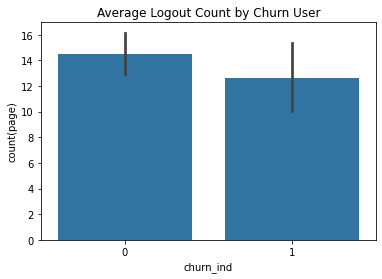

In [191]:
sns.barplot(data=users_pageAction_count.query('page=="Logout"'), x='churn_ind', y='count(page)', color=base_colour)
plt.title('Average Logout Count by Churn User');

Non-churn users use the logout button slightly more than churn users.

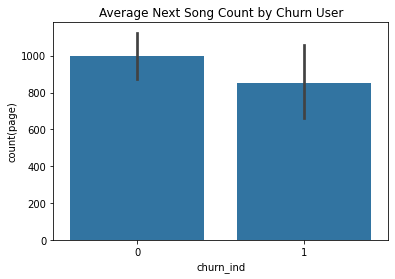

In [186]:
sns.barplot(data=users_pageAction_count.query('page=="NextSong"'), x='churn_ind', y='count(page)', color=base_colour)
plt.title('Average Next Song Count by Churn User');

Churn users listen to fewer songs than non-churn users.

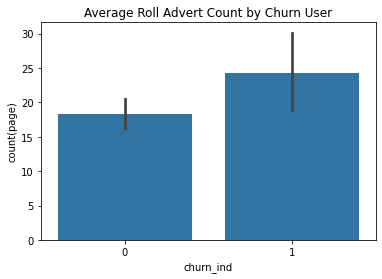

In [185]:
sns.barplot(data=users_pageAction_count.query('page=="Roll Advert"'), x='churn_ind', y='count(page)', color=base_colour)
plt.title('Average Roll Advert Count by Churn User');

Churn users roll adverts much more than non-churn users.

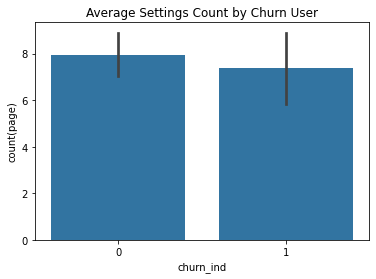

In [192]:
sns.barplot(data=users_pageAction_count.query('page=="Settings"'), x='churn_ind', y='count(page)', color=base_colour)
plt.title('Average Settings Count by Churn User');

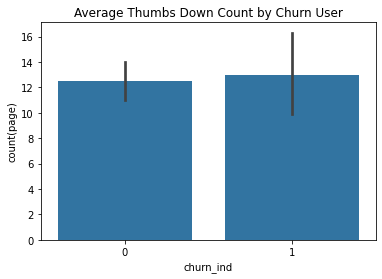

In [183]:
sns.barplot(data=users_pageAction_count.query('page=="Thumbs Down"'), x='churn_ind', y='count(page)', color=base_colour)
plt.title('Average Thumbs Down Count by Churn User');

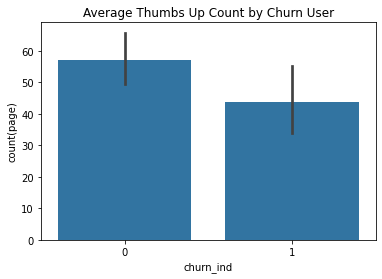

In [184]:
sns.barplot(data=users_pageAction_count.query('page=="Thumbs Up"'), x='churn_ind', y='count(page)', color=base_colour)
plt.title('Average Thumbs Up Count by Churn User');

Churn users give more thumbs downs and fewer thumbs ups than non-churn users.

In [53]:
gender_churn = df_data_6.select('userId', 'gender', 'churn_ind').dropDuplicates().groupby('gender').agg(avg('churn_ind'))
gender_churn.show()

+------+-------------------+
|gender|     avg(churn_ind)|
+------+-------------------+
|     F|0.22727272727272727|
|     M|              0.216|
+------+-------------------+



In [54]:
# define base colour
base_colour = sns.color_palette()[0]

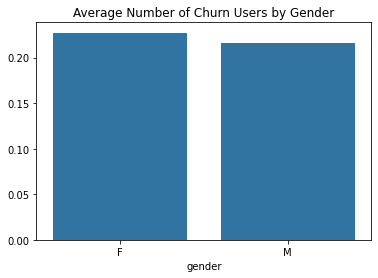

In [55]:
# display average churn by gender
gender_churn = df_data_6.select('userId', 'gender', 'churn_ind').dropDuplicates().groupby('gender').agg(avg('churn_ind'))
gender_churn_pd = gender_churn.toPandas()
sns.barplot(x='gender', y='avg(churn_ind)', data=gender_churn_pd, color=base_colour)
plt.title('Average Number of Churn Users by Gender')
plt.ylabel('');

In [56]:
avg_iIS_churn = df_data_6.groupby('churn_ind').agg(avg('itemInSession'))
avg_iIS_churn.show()

+---------+------------------+
|churn_ind|avg(itemInSession)|
+---------+------------------+
|        0|107.84486484321059|
|        1| 107.5093008895664|
+---------+------------------+



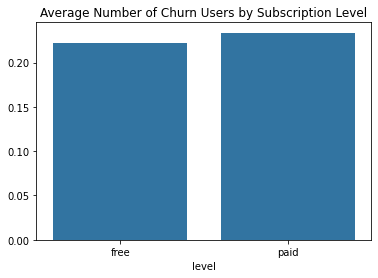

In [57]:
# display average churn by level type
level_churn = df_data_6.select('userId', 'level', 'churn_ind').dropDuplicates().groupby('level').agg(avg('churn_ind'))
level_churn_pd = level_churn.toPandas()
sns.barplot(x='level', y='avg(churn_ind)', data=level_churn_pd, color=base_colour)
plt.title('Average Number of Churn Users by Subscription Level')
plt.ylabel('');



*   Paid users are more likely to churn. This makes sense, given they pay for the service.
*   Female users are more likely to churn.
*   No difference in the item in session counts between churn and non-churn users



In [58]:
df_data_6.createOrReplaceTempView("df")

# create item in session interaction with page
df_data_7 = spark.sql(
    """SELECT *,
    time - registration_time as registration_length
    FROM df
     """)

# create registration length table by churn user
df_data_7.createOrReplaceTempView("df")

df_data_7_1 = spark.sql(
    """SELECT userId, 
    max(churn_ind) as churn_ind, 
    max(registration_length) as registration_length
    FROM df
    GROUP BY userId
     """)

In [59]:
time_churn = df_data_7_1.groupby('churn_ind').agg(avg('registration_length'))
time_churn.show()

+---------+------------------------+
|churn_ind|avg(registration_length)|
+---------+------------------------+
|        0|    INTERVAL '86 23:3...|
|        1|    INTERVAL '68 00:1...|
+---------+------------------------+



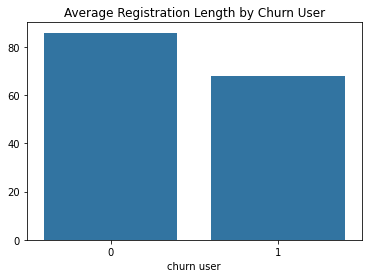

In [60]:
# display average registration length by churn user group
time_churn = df_data_7_1.groupby('churn_ind').agg(avg('registration_length'))
time_churn_pd = time_churn.toPandas()
sns.barplot(x=time_churn_pd.churn_ind, y=time_churn_pd['avg(registration_length)'].dt.days, color=base_colour)
plt.ylabel('')
plt.title('Average Registration Length by Churn User')
plt.xlabel('churn user');



*   Newer users are more likely to cancel than older users



In [409]:
df_data_7.createOrReplaceTempView("df")

# create session length variable
df_data_7_2 = spark.sql(
    """SELECT userId,
    churn_ind,
    sessionId,
    (max(ts) - min(ts))/(3600*1000) as session_length
    FROM df
    GROUP BY userId, churn_ind, sessionId
    ORDER BY userId
     """)

In [410]:
df_data_7_2.groupby('churn_ind').agg(avg('session_length')).show()

+---------+-------------------+
|churn_ind|avg(session_length)|
+---------+-------------------+
|        0|  4.960445821102705|
|        1|  4.897831616077221|
+---------+-------------------+



Not much difference between the two groups

In [61]:
# filter out non null rows
df_data_8 = df_data_7.filter(df_data_7.userAgent.isNotNull() & df_data_7.lastName.isNotNull()).dropDuplicates()

In [62]:
# filter for potential features and label columns
df_data_9 = df_data_8.select(['userId', 'gender', 'level', 'page', 'ts', 'time', 'registration_length', 'churn', 'churn_ind', 'final_week_churn_ind'])

In [368]:
# get unique list of pages.
unique_pages = list(df_data_9.select('page').dropDuplicates().collect())
categories = [page.page for page in unique_pages]

# create indicator columns for pages of interest
for category in categories:
    function = udf(lambda item: 1 if item == category else 0, IntegerType())
    new_column_name = 'ind'+'_'+category.replace(' ','_').lower()
    df_data_9 = df_data_9.withColumn(new_column_name, function(col('page')))

In [372]:
df_data_9.createOrReplaceTempView("df")

# create count of page actions by userId
df_data_10 = spark.sql(
    """SELECT 
    userId,
    gender,
    level,
    time,
    ts,
    churn_ind,
    registration_length,
    sum(ind_add_friend) OVER w AS addFriend_cnt,
    sum(ind_add_to_playlist) OVER w AS addToPlaylist_cnt,
    sum(ind_nextsong) OVER w AS nextSong_cnt,
    sum(ind_roll_advert) OVER w AS rollAdvert_cnt,
    sum(ind_thumbs_down) OVER w AS thumbsDown_cnt,
    sum(ind_thumbs_up) OVER w AS thumbsUp_cnt,
    sum(ind_downgrade) OVER w AS downgrade_cnt,
    sum(ind_help) OVER w AS help_cnt,
    sum(ind_home) OVER w AS home_cnt,
    sum(ind_logout) OVER w AS logout_cnt,
    sum(ind_settings) OVER w AS settings_cnt
    FROM df
    WINDOW w AS (
        PARTITION BY userId
     )""")

In [374]:
df_data_10.createOrReplaceTempView("df")

# collapse down to latest date
df_data_11 = spark.sql(
    """SELECT
    a.userId,
    gender,
    level,
    time,
    ts,
    registration_length,
    churn_ind,
    addFriend_cnt,
    addToPlaylist_cnt,
    nextSong_cnt,
    rollAdvert_cnt,
    thumbsDown_cnt,
    thumbsUp_cnt,
    downgrade_cnt,
    help_cnt,
    home_cnt,
    logout_cnt,
    settings_cnt
    FROM df a
    INNER JOIN(
    SELECT
    userId,
    max(ts) as max_ts
    FROM df
    GROUP BY userId) b
    ON a.ts = b.max_ts
    """)

In [376]:
df_data_11.show()

+------+------+-----+----------+-------------+-------------------+---------+-------------+-----------------+------------+--------------+--------------+------------+-------------+--------+--------+----------+------------+
|userId|gender|level|      time|           ts|registration_length|churn_ind|addFriend_cnt|addToPlaylist_cnt|nextSong_cnt|rollAdvert_cnt|thumbsDown_cnt|thumbsUp_cnt|downgrade_cnt|help_cnt|home_cnt|logout_cnt|settings_cnt|
+------+------+-----+----------+-------------+-------------------+---------+-------------+-----------------+------------+--------------+--------------+------------+-------------+--------+--------+----------+------------+
|   100|     M| paid|2018-11-30|1543606468000|  INTERVAL '65' DAY|        0|           71|               94|        3382|             8|            37|         143|           40|      17|     135|        36|          17|
|100004|     F| free|2018-10-14|1539511980000| INTERVAL '127' DAY|        1|            7|                7|        

In [375]:
# count of users after aggregation
df_data_11.groupby('churn_ind').count().show()

+---------+-----+
|churn_ind|count|
+---------+-----+
|        0|  384|
|        1|  110|
+---------+-----+



In [377]:
# create gender indicator column
gender_ind = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
df_data_12 = df_data_11.withColumn('male_ind', gender_ind(df_data_11.gender))

# create user level indicator column
level_ind = udf(lambda x: 1 if x == 'Paid' else 0, IntegerType())
df_data_13 = df_data_12.withColumn('paid_ind', gender_ind(df_data_12.level))

In [378]:
# define label column
df_data_14 = df_data_13.withColumn('label', col('churn_ind'))

In [379]:
# convert timedelta object to days
td_to_hours = udf(lambda x: x / datetime.timedelta(hours=1), FloatType())
df_data_15 = df_data_14.withColumn('registration_length_hours', td_to_hours(df_data_14.registration_length))

## Modelling

In [443]:
# define feature columns
cols_to_standardise = ['registration_length_hours',
    'addFriend_cnt',
    'addToPlaylist_cnt',
    'nextSong_cnt',
    'rollAdvert_cnt',
    'thumbsDown_cnt',
    'thumbsUp_cnt',
    'downgrade_cnt',
    'help_cnt',
    'home_cnt',
    'logout_cnt',
    'settings_cnt']

# initialise vector assesmbler to convert above cols to vector
vectorassembler_standardise = VectorAssembler(inputCols=cols_to_standardise, outputCol='cols_to_standardise')

# initialise standard scaler. This is preferred to minmaxscaler when data is likely to be normal.
num_scaler = StandardScaler(inputCol='cols_to_standardise', outputCol ='standardised_cols', withStd=True, withMean=True)

# convert features to be standardised into vector
df_data_16 = vectorassembler_standardise.transform(df_data_15)
# fit scaler model
scaler_model = num_scaler.fit(df_data_16)
# scale data
df_data_16 = scaler_model.transform(df_data_16)

# define feature columns to be vectorised
vectorassembler = VectorAssembler(inputCols=['standardised_cols', 'male_ind', 'paid_ind'], outputCol='features')

# add feature column to data
df_data_16 = vectorassembler.transform(df_data_16)

In [444]:
# select modelling columns
df_data_17 = df_data_16.select('features', 'label')

In [448]:
# split into training and test data
train_df, test_df = df_data_17.randomSplit([0.6,0.4], 42)

# cache data in memory to speed up performance
train_df.persist()
test_df.persist()

DataFrame[features: vector, label: bigint]

In [456]:
def make_preds(clf, train_df=train_df, test_df=test_df):
    """
    This function takes in a machine learning classifier, a training set, a test set
    and the evaluation metric of choice.
    It trains the model on the training set data and outputs the metric results
    after evaluating on the test set.
    """
    model_name = clf
    # start timer
    start = time.time()
    # instatiate model
    model = clf()
    # fit model
    print('fitting model...')
    fitmodel = model.fit(train_df)
    # predict on test data
    print('fitting model to test set...')
    predictions_test = fitmodel.transform(test_df)
    # instatiate evaluators
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
    evaluator_recall = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
    evaluator_precision = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
    # evaluate test predictions
    print('evaluating model...')
    accuracy_score = evaluator_accuracy.evaluate(predictions_test)
    f1_score = evaluator_f1.evaluate(predictions_test)
    recall_score = evaluator_recall.evaluate(predictions_test)
    precision_score = evaluator_precision.evaluate(predictions_test)
    
    scores = [accuracy_score, f1_score, recall_score, precision_score]

    # record time taken
    end = time.time()
    time_taken = end-start
    # print score
    print(f'model: {model}\naccuracy:{accuracy_score}\nf1: {f1_score}\nrecall: {recall_score}\nprecision: {precision_score}\ntime taken: {time_taken}')

    return scores

In [467]:
dt_default = make_preds(DecisionTreeClassifier)

fitting model...
fitting model to test set...
evaluating model...
model: DecisionTreeClassifier_b6d5334bdda4
accuracy:0.7806122448979592
f1: 0.7543589518187137
recall: 0.7806122448979592
precision: 0.7514386568580922
time taken: 27.67125630378723


In [469]:
rf_default = make_preds(RandomForestClassifier)

fitting model...
fitting model to test set...
evaluating model...
model: RandomForestClassifier_3cc621003a36
accuracy:0.7806122448979592
f1: 0.7221995893042945
recall: 0.7806122448979592
precision: 0.7466260697827517
time taken: 45.283122062683105


In [470]:
lr_default = make_preds(LogisticRegression)

fitting model...
fitting model to test set...
evaluating model...
model: LogisticRegression_b9e5b00c21a0
accuracy:0.7755102040816326
f1: 0.7388081757093081
recall: 0.7755102040816326
precision: 0.7389053748171883
time taken: 189.01524186134338


In [471]:
gbt_default = make_preds(GBTClassifier)

fitting model...
fitting model to test set...
evaluating model...
model: GBTClassifier_06983d68baff
accuracy:0.7755102040816326
f1: 0.7568885789910048
recall: 0.7755102040816327
precision: 0.750765885540671
time taken: 245.04678440093994


In [472]:
svc_default = make_preds(LinearSVC)

fitting model...
fitting model to test set...
evaluating model...
model: LinearSVC_3ccbe3cbc016
accuracy:0.7704081632653061
f1: 0.670499323648768
recall: 0.7704081632653061
precision: 0.5935287380258226
time taken: 479.2857632637024


#### Metrics

*   Where there is a class label imbalance, accuracy may not be a good optimisation metric, as a model could perform well by simply predicting a single class.


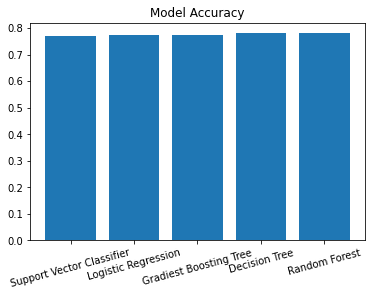

In [480]:
model_names = ['Decision Tree', 'Random Forest', 'Support Vector Classifier', 'Logistic Regression', 'Gradiest Boosting Tree']

# plot accuracies
accuracy = [dt_default[0], rf_default[0], svc_default[0], lr_default[0], gbt_default[0]]
sorted_model_names_acc = [x for _, x in sorted(zip(accuracy, model_names), key=lambda pair: pair[0])]
plt.bar(x=sorted_model_names_acc, height=sorted(accuracy))
plt.xticks(rotation=15)
plt.title('Model Accuracy');

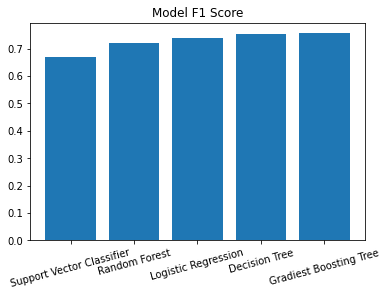

In [481]:
# plot f1 scores
f1_scores = [dt_default[1], rf_default[1], svc_default[1], lr_default[1], gbt_default[1]]
sorted_model_names_f1 = [x for _, x in sorted(zip(f1_scores, model_names), key=lambda pair: pair[0])]
plt.bar(x=sorted_model_names_f1, height=sorted(f1_scores))
plt.xticks(rotation=15)
plt.title('Model F1 Score');

### Hyperparameter Tuning



*   Given the relatively quick training time and high test accuracy using the default parameters, I will select the Random Forest algorithm to optimise.
*   Given the skew of labels to one class (i.e. many more that did not churn than did churn), I will use the f1 score as the optimisation metric. This metric combines the recall and precision scores into a composite metric.
*   Sparkify might consider optimising their model using the precision metric, if they wanted make the model sensitive to users who might want to cancel.


*   Parameters to optimise:
    *   impurity criterion: this defines how to measure the quality of each variable split
    *   max features: this defines how many variables to consider when looking for the best split
    *   number of trees: the number of decision trees to average over

In [475]:
def rf_tuning(metric='f1'):  
  # define the classifier estimator
  clf = RandomForestClassifier()

  # define the parameters to iterate through
  paramGrid = ParamGridBuilder()\
  .addGrid(clf.impurity, ['gini', 'entropy'])\
  .addGrid(clf.featureSubsetStrategy, ['sqrt', 'log2'])\
  .addGrid(clf.numTrees, [20, 40])\
  .build()

  # define the evaluator.
  evaluator=MulticlassClassificationEvaluator(metricName=metric) 

  # initialise the cross validation model
  crossval = CrossValidator(estimator=clf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)

  print('fitting cross validation model..')
  # fit the cross validation model
  crossval_model = crossval.fit(train_df)

  avg_score = np.average(crossval_model.avgMetrics)

  print('predicting test set..')
 
  predictions = crossval_model.transform(test_df)
  
  evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
  # evaluate test predictions
  print('evaluating model...')
  f1_score = evaluator_f1.evaluate(predictions)

  print(f'model: {clf}, avg_training_score: {avg_score}, test_f1_score: {f1_score}')

  return crossval_model

In [476]:
rf_model = rf_tuning()

fitting cross validation model..
predicting test set..
evaluating model...
model: RandomForestClassifier_9dc34e05a96f, avg_training_score: 0.7555256115003661, test_f1_score: 0.7518214386346255


In [477]:
def dt_tuning(metric='f1'):  
  # define the classifier estimator
  clf = DecisionTreeClassifier()

  # define the parameters to iterate through
  paramGrid = ParamGridBuilder()\
  .addGrid(clf.impurity, ['gini', 'entropy'])\
  .addGrid(clf.maxDepth, [2, 5, 10])\
  .build()

  # define the evaluator.
  evaluator=MulticlassClassificationEvaluator(metricName=metric) 

  # initialise the cross validation model
  crossval = CrossValidator(estimator=clf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)

  print('fitting cross validation model..')
  # fit the cross validation model
  crossval_model = crossval.fit(train_df)

  avg_score = np.average(crossval_model.avgMetrics)

  print('predicting test set..')
 
  predictions = crossval_model.transform(test_df)
  
  evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
  # evaluate test predictions
  print('evaluating model...')
  f1_score = evaluator_f1.evaluate(predictions)

  print(f'model: {clf}, avg_training_score: {avg_score}, test_f1_score: {f1_score}')

  return crossval_model


In [478]:
dt_model = dt_tuning()

fitting cross validation model..
predicting test set..
evaluating model...
model: DecisionTreeClassifier_a255c15f0091, avg_training_score: 0.7410565195383032, test_f1_score: 0.7239480496687289


  ### Results

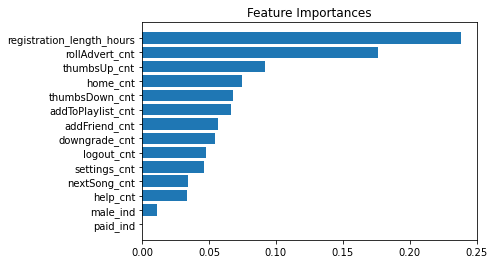

In [464]:
# display features importances
Y = rf_model.bestModel.featureImportances
X = cols_to_standardise + ['male_ind', 'paid_ind']
inputcols_sorted = [x for _, x in sorted(zip(Y, X), key=lambda pair: pair[0])]

plt.barh(y=inputcols_sorted, width=sorted(Y))
plt.title('Feature Importances');

In [465]:
bestModel = rf_model.bestModel

print(f'Best Impurity Param: {bestModel._java_obj.getImpurity()}')
print(f'Best Feature Subset Strategy Param: {bestModel._java_obj.getFeatureSubsetStrategy()}')
print(f'Best NumTrees Param: {bestModel._java_obj.getNumTrees()}')

Best Impurity Param: entropy
Best Feature Subset Strategy Param: sqrt
Best NumTrees Param: 40


### Reflection



*   Interestingly, the gender feature does not appear as an important feature in the model.
*   Similarly, the level feature has no importance in the model.
*   The most key features is the length of time since registration. Sparkify should spend more time thinking about how to better onboard their users.
*   Other important features relate to how a user interacts with the platform. These should be monitored periodically to identify users who may be disatisfied.



### Improvements

This study only analyses two weeks of Sparkify data. An analysis over a longer period of time would give more credibility to the results and modelling. In addition, Sparkify might consider doing this study periodically in case their user demographic changed.

